<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üî• (WGAN's) Wasserstein || Generative-AIüî•</div>
</div>

<div class="text_cell_render border-box-sizing rendered_html">
<div style="text-align:center">
    <img src="https://i.ytimg.com/vi/pG0QZ7OddX4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLDAVW-mMQr3H_4hoxY8SKD_jqV5wg
" alt="Image">
</div>
</div>

### Understanding Wasserstein GAN (WGAN)

**Wasserstein GAN (WGAN)** is a variant of the traditional Generative Adversarial Network (GAN) that aims to improve training stability and address issues like mode collapse. The key differences and concepts are:

1. **Critic Instead of Discriminator**:
   - Traditional GANs use a discriminator to classify inputs as real or fake.
   - WGAN replaces the discriminator with a critic that scores the "realness" of inputs without using a sigmoid activation function.

2. **Wasserstein Distance**:
   - WGAN minimizes the Wasserstein distance (also known as Earth Mover's distance) between the real and generated data distributions.
   - This distance provides a smoother and more meaningful measure of differences between distributions compared to the Jensen-Shannon divergence used in traditional GANs.

3. **Weight Clipping**:
   - To enforce the Lipschitz constraint required for the Wasserstein distance, the weights of the critic are clipped to a small fixed range (e.g., [-0.01, 0.01]).
   - This ensures that the critic function is 1-Lipschitz continuous.

4. **Training Stability**:
   - WGANs improve training stability and provide a more reliable training process.
   - They address common issues like mode collapse, where the generator produces limited diversity in generated samples.

5. **Gradient Penalty**:
   - An enhancement called WGAN-GP (WGAN with Gradient Penalty) replaces weight clipping with a gradient penalty term.
   - This term penalizes the norm of the gradient of the critic with respect to its input, ensuring the Lipschitz constraint more effectively.

### Advantages of WGAN:
- **Improved Training Dynamics**: More stable and reliable training process compared to traditional GANs.
- **Better Loss Metric**: The loss function correlates with the quality of generated samples, providing a meaningful metric during training.
- **Reduced Mode Collapse**: More diverse and realistic outputs from the generator.

### Summary:
WGAN offers a robust approach to training GANs by introducing the Wasserstein distance, replacing the discriminator with a critic, and employing techniques like weight clipping or gradient penalty to enforce Lipschitz continuity. These improvements result in a more stable training process and higher-quality generated samples.

<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üìö Importing Libraries üìö</div>
</div>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt

2024-07-06 03:04:54.780817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 03:04:54.780924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 03:04:54.936869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üìö Loading Dataset üìö</div>
</div>

In [2]:
# Load and preprocess dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üõ† Normalization üõ†</div>
</div>

In [3]:
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üî• WGAN - Wasserstein Model üî•</div>
</div>

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64
noise_dim = 100
num_examples_to_generate = 16

In [5]:
# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<div class="text_cell_render border-box-sizing rendered_html">
<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>Creating a TensorFlow Dataset Explanation</h2>
        <p>The provided code snippet creates a TensorFlow dataset from training data, shuffles the data, and batches it for training purposes.</p>
        <ul>
            <li><b>Step 1: Dataset Initialization</b>
                <ul>
                    <li>The <code>tf.data.Dataset.from_tensor_slices(x_train)</code> function converts the <code>x_train</code> NumPy array into a <code>tf.data.Dataset</code> object.</li>
                    <li>Each element in the dataset corresponds to a single sample from the <code>x_train</code> array.</li>
                </ul>
            </li>
            <li><b>Step 2: Shuffling the Dataset</b>
                <ul>
                    <li>The <code>.shuffle(BUFFER_SIZE)</code> method randomly shuffles the elements of the dataset.</li>
                    <li>The <code>BUFFER_SIZE</code> parameter determines the size of the buffer from which elements are sampled, ensuring thorough shuffling.</li>
                </ul>
            </li>
            <li><b>Step 3: Batching the Dataset</b>
                <ul>
                    <li>The <code>.batch(BATCH_SIZE)</code> method groups the dataset elements into batches of size <code>BATCH_SIZE</code>.</li>
                    <li>This allows the model to process multiple samples in parallel, enhancing training efficiency and stability.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>
</div>

<div class="text_cell_render border-box-sizing rendered_html">
  <div style="color:black; border: 2px solid #ff6347; background-color:#ff6347; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Arial', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); box-shadow: 0 4px 8px rgba(0, 0, 0, 0.4);">
   ‚úî Generator Model ‚úî
  </div>
</div>

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>Building a Generator Model Explanation</h2>
        <p>The provided code snippet constructs a generator model for a DCGAN using TensorFlow and Keras. This model generates synthetic images from random noise.</p>
        <ul>
            <li><b>Step 1: Model Initialization</b>
                <ul>
                    <li>The <code>tf.keras.Sequential()</code> function initializes a sequential model, allowing layers to be added one after the other.</li>
                </ul>
            </li>
            <li><b>Step 2: Dense Layer</b>
                <ul>
                    <li>The <code>layers.Dense(7*7*256, use_bias=False, input_shape=(100,))</code> adds a dense (fully connected) layer with 7*7*256 neurons and an input shape of 100. The <code>use_bias=False</code> parameter indicates that no bias terms are used.</li>
                </ul>
            </li>
            <li><b>Step 3: Batch Normalization</b>
                <ul>
                    <li>The <code>model.add(layers.BatchNormalization())</code> layer normalizes the output of the dense layer to stabilize and speed up training.</li>
                </ul>
            </li>
            <li><b>Step 4: ReLU Activation</b>
                <ul>
                    <li>The <code>model.add(layers.ReLU())</code> layer applies the ReLU activation function, introducing non-linearity to the model.</li>
                </ul>
            </li>
            <li><b>Step 5: Reshape Layer</b>
                <ul>
                    <li>The <code>model.add(layers.Reshape((7, 7, 256)))</code> layer reshapes the output into a 7x7x256 tensor, preparing it for upsampling.</li>
                </ul>
            </li>
            <li><b>Step 6: Conv2DTranspose Layer 1</b>
                <ul>
                    <li>The <code>model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))</code> adds a transposed convolutional layer with 128 filters, a 5x5 kernel, a stride of 1x1, and no bias. Padding is set to 'same' to preserve spatial dimensions.</li>
                </ul>
            </li>
            <li><b>Step 7: Batch Normalization</b>
                <ul>
                    <li>Another <code>model.add(layers.BatchNormalization())</code> layer is added for stabilizing the transposed convolution output.</li>
                </ul>
            </li>
            <li><b>Step 8: ReLU Activation</b>
                <ul>
                    <li>The <code>model.add(layers.ReLU())</code> layer applies the ReLU activation function again.</li>
                </ul>
            </li>
            <li><b>Step 9: Conv2DTranspose Layer 2</b>
                <ul>
                    <li>The <code>model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))</code> adds another transposed convolutional layer with 64 filters, a 5x5 kernel, a stride of 2x2, and no bias. Padding is 'same' to maintain spatial dimensions.</li>
                </ul>
            </li>
            <li><b>Step 10: Batch Normalization</b>
                <ul>
                    <li>Another <code>model.add(layers.BatchNormalization())</code> layer normalizes the output.</li>
                </ul>
            </li>
            <li><b>Step 11: ReLU Activation</b>
                <ul>
                    <li>The <code>model.add(layers.ReLU())</code> layer applies the ReLU activation function again.</li>
                </ul>
            </li>
            <li><b>Step 12: Conv2DTranspose Layer 3</b>
                <ul>
                    <li>The final layer, <code>model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))</code>, adds a transposed convolutional layer with 1 filter, a 5x5 kernel, a stride of 2x2, and 'tanh' activation. This produces the output image.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>


<div class="text_cell_render border-box-sizing rendered_html">
  <div style="color:black; border: 2px solid #ff6347; background-color:#ff6347; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Arial', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); box-shadow: 0 4px 8px rgba(0, 0, 0, 0.4);">
   ‚úî Critic Model ‚úî
  </div>
</div>

In [7]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>Building a Critic Model Explanation</h2>
        <p>The provided code snippet constructs a critic model for a WGAN using TensorFlow and Keras. This model distinguishes real images from generated ones.</p>
        <ul>
            <li><b>Step 1: Model Initialization</b>
                <ul>
                    <li>The <code>tf.keras.Sequential()</code> function initializes a sequential model, allowing layers to be added one after the other.</li>
                </ul>
            </li>
            <li><b>Step 2: Conv2D Layer 1</b>
                <ul>
                    <li>The <code>model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))</code> adds a convolutional layer with 64 filters, a 5x5 kernel, a stride of 2x2, and 'same' padding. The input shape is specified as 28x28x1.</li>
                </ul>
            </li>
            <li><b>Step 3: Leaky ReLU Activation</b>
                <ul>
                    <li>The <code>model.add(layers.LeakyReLU())</code> layer applies the Leaky ReLU activation function, allowing a small gradient when the unit is not active.</li>
                </ul>
            </li>
            <li><b>Step 4: Dropout Layer 1</b>
                <ul>
                    <li>The <code>model.add(layers.Dropout(0.3))</code> layer randomly sets 30% of inputs to zero during training, helping to prevent overfitting.</li>
                </ul>
            </li>
            <li><b>Step 5: Conv2D Layer 2</b>
                <ul>
                    <li>The <code>model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))</code> adds another convolutional layer with 128 filters, a 5x5 kernel, a stride of 2x2, and 'same' padding.</li>
                </ul>
            </li>
            <li><b>Step 6: Leaky ReLU Activation</b>
                <ul>
                    <li>The <code>model.add(layers.LeakyReLU())</code> layer applies the Leaky ReLU activation function again.</li>
                </ul>
            </li>
            <li><b>Step 7: Dropout Layer 2</b>
                <ul>
                    <li>The <code>model.add(layers.Dropout(0.3))</code> layer applies dropout again, setting 30% of inputs to zero during training.</li>
                </ul>
            </li>
            <li><b>Step 8: Flatten Layer</b>
                <ul>
                    <li>The <code>model.add(layers.Flatten())</code> layer flattens the output from the previous layer into a 1D tensor, preparing it for the dense layer.</li>
                </ul>
            </li>
            <li><b>Step 9: Dense Layer</b>
                <ul>
                    <li>The final layer, <code>model.add(layers.Dense(1))</code>, adds a dense (fully connected) layer with a single neuron, producing the critic's output score for the input image.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>


In [8]:
# Define the generator and critic models
generator = make_generator_model()
critic = make_critic_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<div class="text_cell_render border-box-sizing rendered_html">
  <div style="color:black; border: 2px solid #ff6347; background-color:#ff6347; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Arial', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); box-shadow: 0 4px 8px rgba(0, 0, 0, 0.4);">
   ‚úî Generator & Critic Model Summary ‚úî
  </div>
</div>

In [9]:
generator.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 12544)          ‚îÇ     1,254,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 12544)          ‚îÇ        50,176 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu (ReLU)                    ‚îÇ (None, 12544)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ reshape (Reshape)               ‚îÇ (None, 7, 7, 256)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose                ‚îÇ (None, 7, 7, 128)      ‚îÇ       819,200 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 7, 7, 128)      ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_1 (ReLU)                  ‚îÇ (None, 7, 7, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_transpose_1              ‚îÇ (None, 14, 14, 64)     ‚îÇ       204,800 ‚îÇ
‚îÇ (Conv2DTranspose)               ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 14, 14, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_2 (ReLU)                  ‚îÇ (None, 14, 14, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [10]:
critic.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 14, 14, 64)     ‚îÇ         1,664 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu (LeakyReLU)         ‚îÇ (None, 14, 14, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 14, 14, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 7, 7, 128)      ‚îÇ       204,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ leaky_re_lu_1 (LeakyReLU)       ‚îÇ (None, 7, 7, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 7, 7, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 6272)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ         6,273 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

![](https://www.researchgate.net/publication/339998063/figure/fig1/AS:870278389317637@1584501945812/Wasserstein-GAN-WGAN.jpg)

In [11]:
# Define the optimizers
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

<div class="text_cell_render border-box-sizing rendered_html">
  <div style="color:black; border: 2px solid #ff6347; background-color:#ff6347; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Arial', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); box-shadow: 0 4px 8px rgba(0, 0, 0, 0.4);">
   ‚úî Model Loss ‚úî
  </div>
</div>

In [12]:
# Define the loss functions
def critic_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>Defining Loss Functions for WGAN</h2>
        <p>The provided code snippet defines the loss functions for the critic and generator in a Wasserstein GAN (WGAN). These loss functions are used to train the models effectively.</p>
        <ul>
            <li><b>Critic Loss Function</b>
                <ul>
                    <li>The <code>critic_loss(real_output, fake_output)</code> function computes the Wasserstein loss for the critic.</li>
                    <li>It calculates the difference between the mean of the fake outputs and the mean of the real outputs: <code>tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)</code>.</li>
                    <li>This encourages the critic to give higher scores to real images and lower scores to fake images, which helps in distinguishing between them.</li>
                </ul>
            </li>
            <li><b>Generator Loss Function</b>
                <ul>
                    <li>The <code>generator_loss(fake_output)</code> function computes the loss for the generator.</li>
                    <li>It is defined as the negative mean of the fake outputs: <code>-tf.reduce_mean(fake_output)</code>.</li>
                    <li>This encourages the generator to produce images that the critic scores higher, effectively making the generated images more realistic.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>


<div class="text_cell_render border-box-sizing rendered_html">
  <div style="color:black; border: 2px solid #ff6347; background-color:#ff6347; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Arial', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7); box-shadow: 0 4px 8px rgba(0, 0, 0, 0.4);">
   ‚úî Gradient Penalty ‚úî
  </div>
</div>

In [13]:
def gradient_penalty(real_images, fake_images):
    batch_size = tf.minimum(tf.shape(real_images)[0], tf.shape(fake_images)[0])
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    real_images = real_images[:batch_size]
    fake_images = fake_images[:batch_size]
    interpolated = alpha * real_images + (1 - alpha) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated)
    
    grads = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return gradient_penalty

<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>Gradient Penalty for WGAN Explanation</h2>
        <p>The provided code snippet computes the gradient penalty for the Wasserstein GAN (WGAN), enforcing the Lipschitz constraint on the critic.</p>
        <ul>
            <li><b>Batch Size Determination</b>
                <ul>
                    <li>The <code>batch_size</code> is calculated as the minimum of the batch sizes of real and fake images, ensuring consistency.</li>
                </ul>
            </li>
            <li><b>Alpha Initialization</b>
                <ul>
                    <li>The <code>alpha</code> tensor is created with a shape of <code>[batch_size, 1, 1, 1]</code> and values sampled from a normal distribution between 0.0 and 1.0.</li>
                </ul>
            </li>
            <li><b>Image Reshaping</b>
                <ul>
                    <li>The <code>real_images</code> and <code>fake_images</code> are sliced to match the determined <code>batch_size</code>.</li>
                </ul>
            </li>
            <li><b>Interpolated Images</b>
                <ul>
                    <li>The <code>interpolated</code> images are computed as a weighted sum of real and fake images using the formula: <code>interpolated = alpha * real_images + (1 - alpha) * fake_images</code>.</li>
                </ul>
            </li>
            <li><b>Gradient Calculation</b>
                <ul>
                    <li>A <code>tf.GradientTape</code> context is used to watch the <code>interpolated</code> images and compute the critic's predictions on them.</li>
                    <li>The gradients of these predictions with respect to the <code>interpolated</code> images are calculated using <code>tape.gradient(pred, interpolated)</code>.</li>
                </ul>
            </li>
            <li><b>Gradient Norm Calculation</b>
                <ul>
                    <li>The gradient norms are computed by summing the squares of the gradients across all dimensions and taking the square root: <code>norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))</code>.</li>
                </ul>
            </li>
            <li><b>Gradient Penalty</b>
                <ul>
                    <li>The gradient penalty is computed as the mean squared difference between the gradient norms and 1.0: <code>gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)</code>.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>


<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üî• WGAN - Wasserstein Model Prediction Savingüî•</div>
</div>

In [14]:
# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


<div class="text_cell_render border-box-sizing rendered_html">
<div style="color:black; border: 2px solid #6f42c1; background-color:#f3e8ff; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">üî• WGAN - Wasserstein Model Trainingüî•</div>
</div>

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    for _ in range(5):
        with tf.GradientTape() as critic_tape:
            generated_images = generator(noise, training=True)

            real_output = critic(images, training=True)
            fake_output = critic(generated_images, training=True)

            crit_loss = critic_loss(real_output, fake_output)
            gp = gradient_penalty(images, generated_images)
            total_crit_loss = crit_loss + 10.0 * gp

        gradients_of_critic = critic_tape.gradient(total_crit_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = critic(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>WGAN Training Step Explanation</h2>
        <p>The provided code snippet defines a single training step for the Wasserstein GAN (WGAN), involving updates to both the generator and critic (discriminator) networks.</p>
        <ul>
            <li><b>Noise Generation</b>
                <ul>
                    <li>The <code>noise</code> tensor is created with a shape of <code>[BATCH_SIZE, noise_dim]</code>, sampled from a normal distribution.</li>
                </ul>
            </li>
            <li><b>Critic Updates</b>
                <ul>
                    <li>The critic (discriminator) is updated multiple times (5 in this case) per generator update.</li>
                    <li>Within a <code>tf.GradientTape</code> context:
                        <ul>
                            <li>Generate images using the generator.</li>
                            <li>Obtain the critic's predictions for both real and generated (fake) images.</li>
                            <li>Compute the critic loss using the difference between real and fake outputs.</li>
                            <li>Compute the gradient penalty for the Lipschitz constraint.</li>
                            <li>Calculate the total critic loss as the sum of the critic loss and the gradient penalty.</li>
                        </ul>
                    </li>
                    <li>Compute the gradients of the total critic loss with respect to the critic's trainable variables.</li>
                    <li>Apply these gradients to update the critic's parameters using the optimizer.</li>
                </ul>
            </li>
            <li><b>Generator Update</b>
                <ul>
                    <li>Within a <code>tf.GradientTape</code> context:
                        <ul>
                            <li>Generate images using the generator.</li>
                            <li>Obtain the critic's predictions for the generated (fake) images.</li>
                            <li>Compute the generator loss using the critic's output for fake images.</li>
                        </ul>
                    </li>
                    <li>Compute the gradients of the generator loss with respect to the generator's trainable variables.</li>
                    <li>Apply these gradients to update the generator's parameters using the optimizer.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>


2024-07-06 03:05:17.340926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-06 03:06:23.060368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


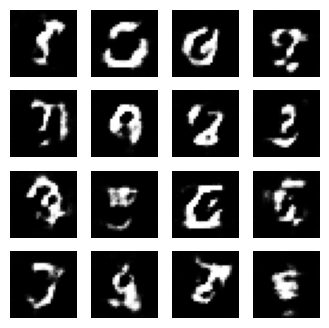

Epoch 1 completed


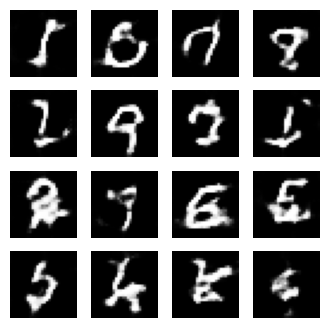

Epoch 2 completed


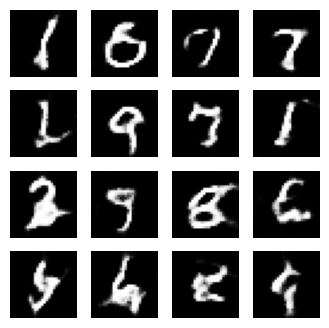

Epoch 3 completed


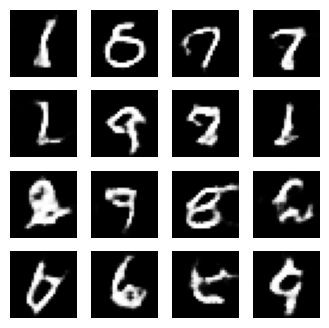

Epoch 4 completed


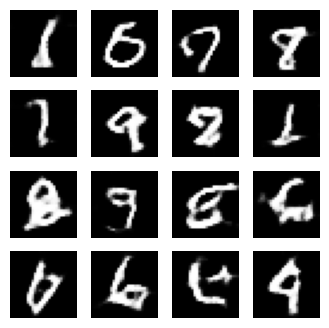

Epoch 5 completed


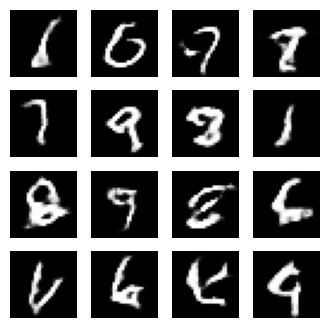

Epoch 6 completed


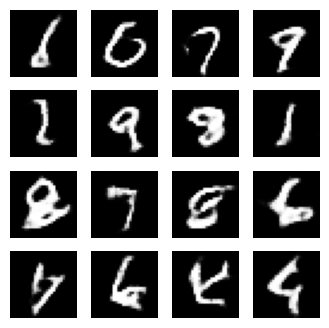

Epoch 7 completed


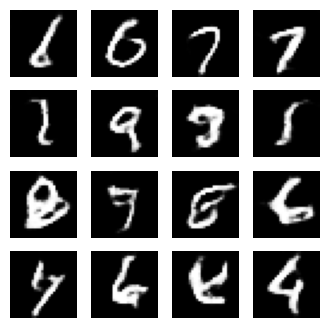

Epoch 8 completed


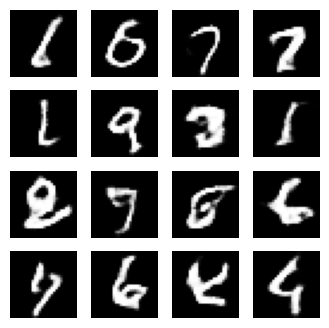

Epoch 9 completed


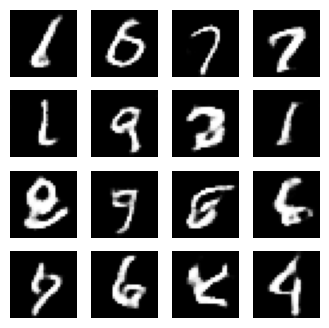

Epoch 10 completed


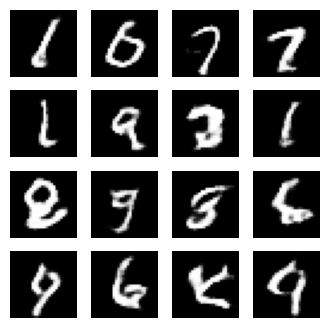

Epoch 11 completed


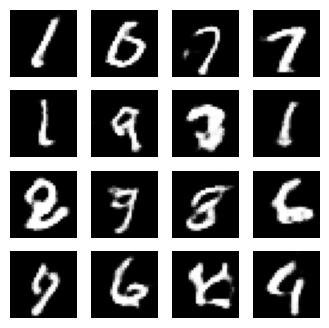

Epoch 12 completed


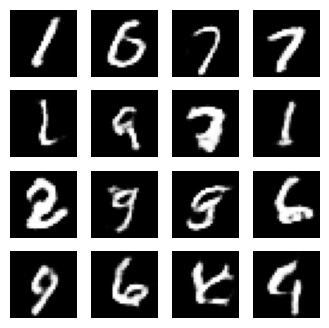

Epoch 13 completed


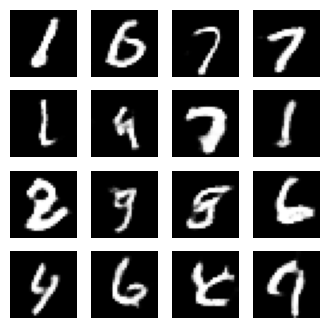

Epoch 14 completed


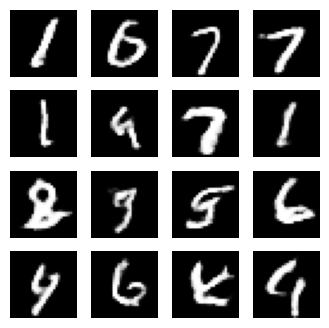

Epoch 15 completed


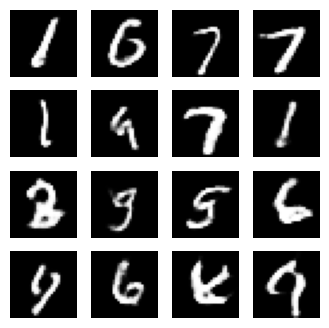

Epoch 16 completed


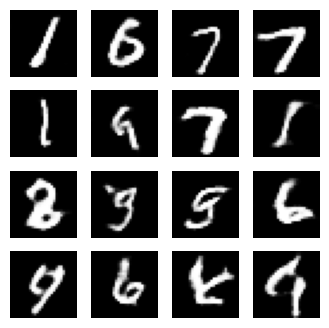

Epoch 17 completed


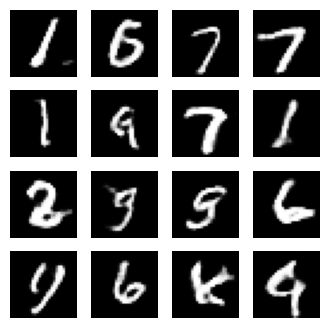

Epoch 18 completed


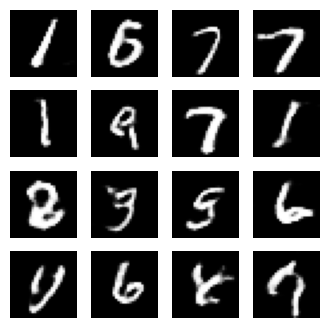

Epoch 19 completed


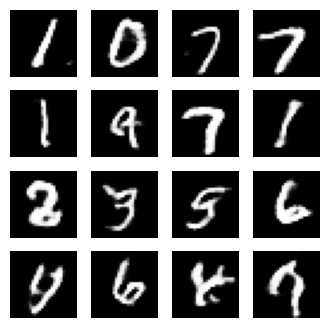

Epoch 20 completed


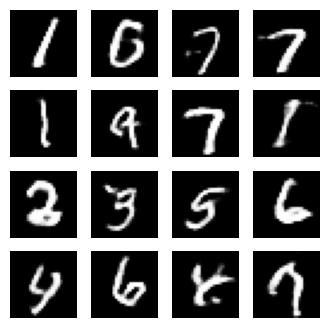

Epoch 21 completed


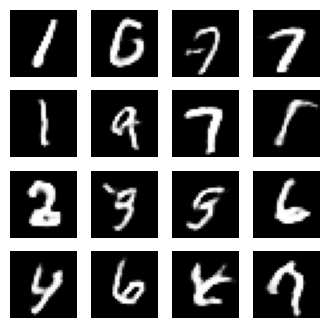

Epoch 22 completed


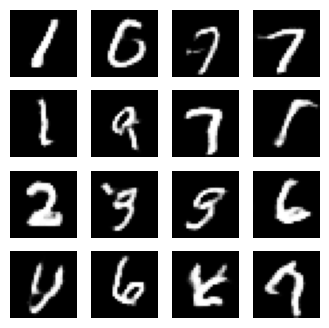

Epoch 23 completed


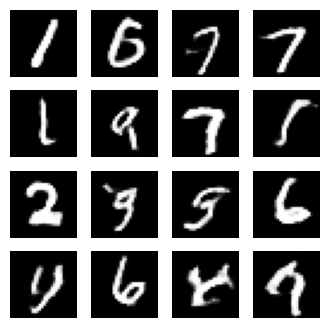

Epoch 24 completed


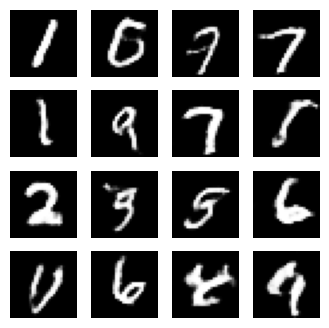

Epoch 25 completed


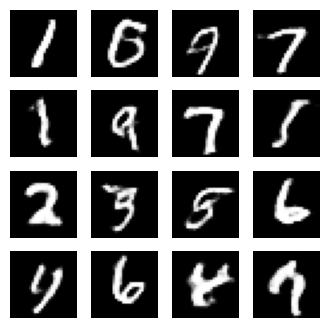

Epoch 26 completed


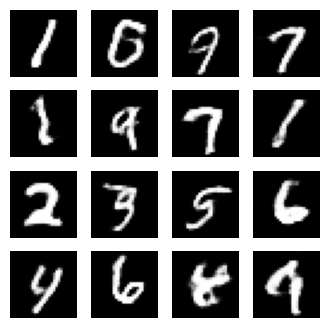

Epoch 27 completed


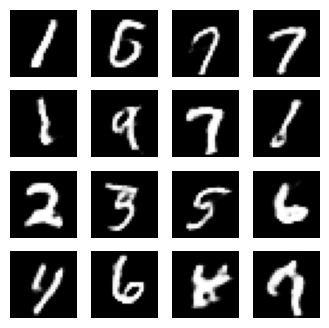

Epoch 28 completed


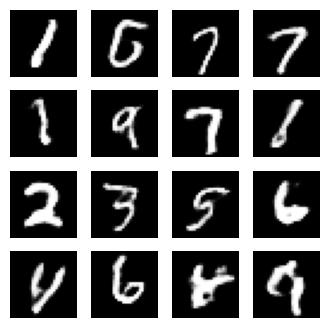

Epoch 29 completed


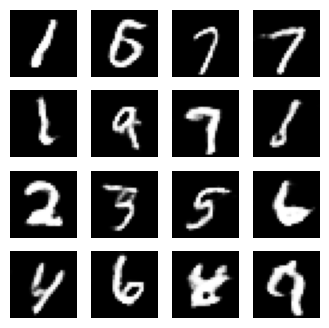

Epoch 30 completed


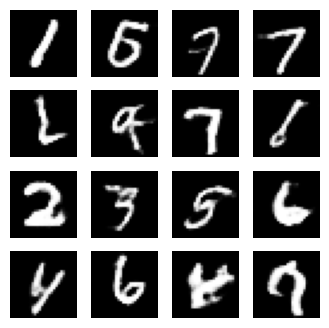

Epoch 31 completed


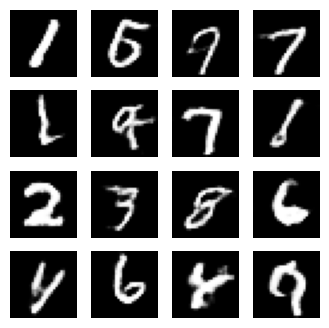

Epoch 32 completed


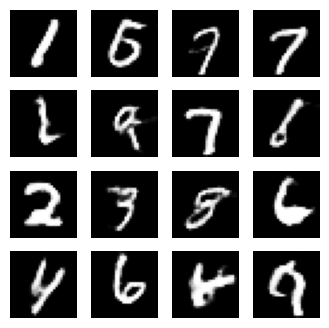

Epoch 33 completed


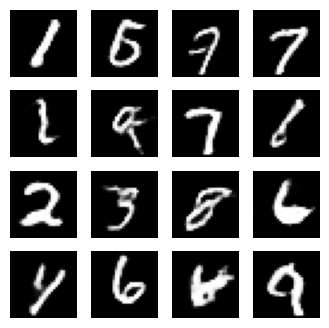

Epoch 34 completed


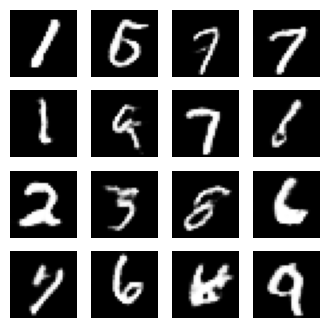

Epoch 35 completed


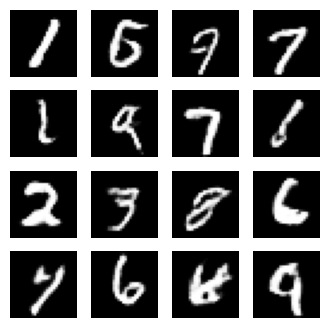

Epoch 36 completed


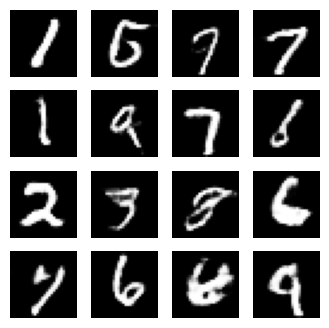

Epoch 37 completed


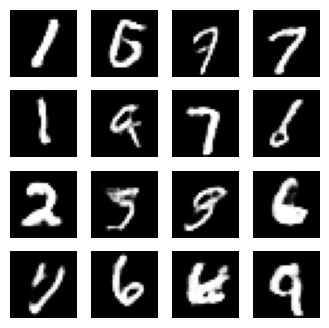

Epoch 38 completed


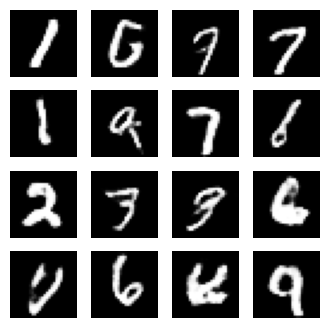

Epoch 39 completed


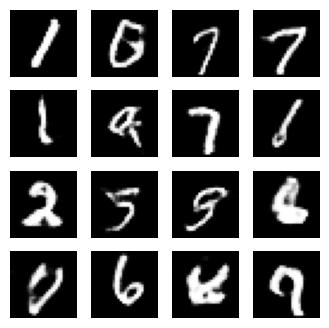

Epoch 40 completed


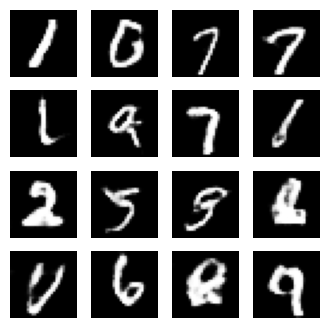

Epoch 41 completed


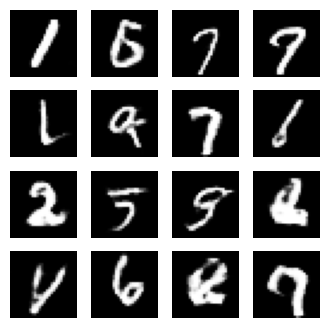

Epoch 42 completed


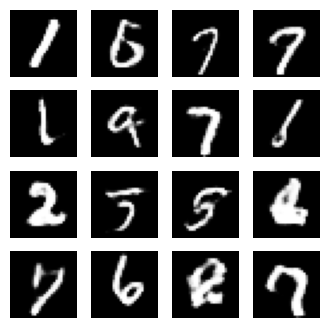

Epoch 43 completed


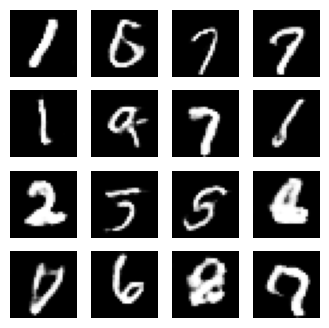

Epoch 44 completed


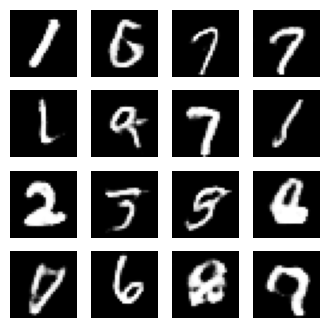

Epoch 45 completed


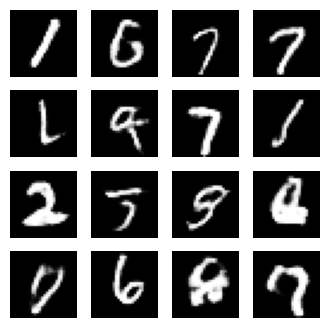

Epoch 46 completed


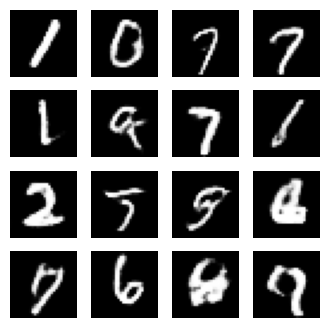

Epoch 47 completed


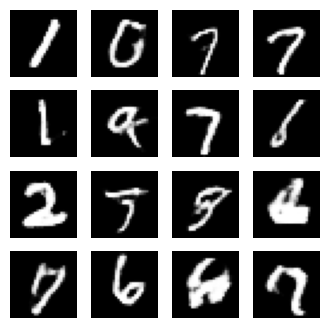

Epoch 48 completed


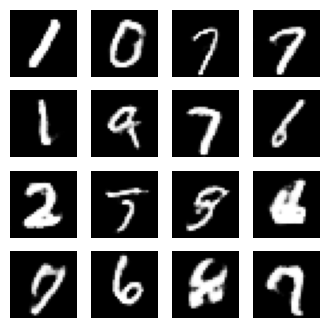

Epoch 49 completed


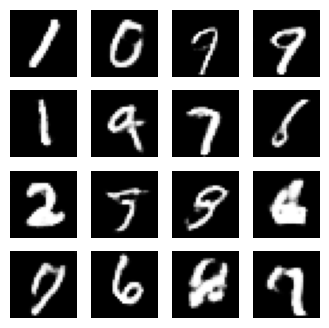

Epoch 50 completed


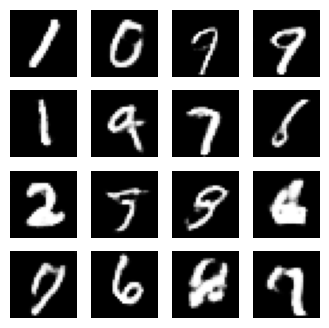

In [16]:
def train(dataset, epochs):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Epoch {epoch + 1} completed')

    generate_and_save_images(generator, epochs, seed)

# Train the WGAN
EPOCHS = 50
train(train_dataset, EPOCHS)

<div class="text_cell_render border-box-sizing rendered_html">
    <div style="color:black; border: 2px solid #6f31c1; background-color:#ffffff; padding: 20px; border-radius: 15px; font-size: 16px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:left; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
        <h2>WGAN Training Loop Explanation</h2>
        <p>The provided code snippet defines the training loop for the Wasserstein GAN (WGAN), involving multiple epochs and the generation of images for each epoch.</p>
        <ul>
            <li><b>Seed Initialization</b>
                <ul>
                    <li>A <code>seed</code> tensor is created with a shape of <code>[num_examples_to_generate, noise_dim]</code>, sampled from a normal distribution.</li>
                    <li>This seed will be used for generating and saving images consistently across epochs.</li>
                </ul>
            </li>
            <li><b>Epoch Loop</b>
                <ul>
                    <li>The outer loop iterates over the specified number of epochs.</li>
                </ul>
            </li>
            <li><b>Batch Loop</b>
                <ul>
                    <li>The inner loop iterates over each batch of images in the dataset.</li>
                    <li>For each batch, the <code>train_step</code> function is called to perform the training operations for both the generator and the critic.</li>
                </ul>
            </li>
            <li><b>Image Generation and Saving</b>
                <ul>
                    <li>After processing all batches in an epoch, the <code>generate_and_save_images</code> function is called to generate and save images using the current state of the generator.</li>
                    <li>The images are generated using the predefined <code>seed</code>, ensuring consistency.</li>
                    <li>A message indicating the completion of the current epoch is printed.</li>
                </ul>
            </li>
            <li><b>Final Image Generation</b>
                <ul>
                    <li>After all epochs are completed, the <code>generate_and_save_images</code> function is called one last time to generate and save the final set of images.</li>
                </ul>
            </li>
        </ul>
    </div>
</div>
